In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# each row is 1 image
# 0 is black, 255 is white

In [4]:
train_df = pd.read_csv("mnist_train.csv")
print(len(train_df))
train_df.head()

60000


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df = pd.read_csv("mnist_test.csv")
print(len(test_df))
test_df.head()

10000


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


label: 5


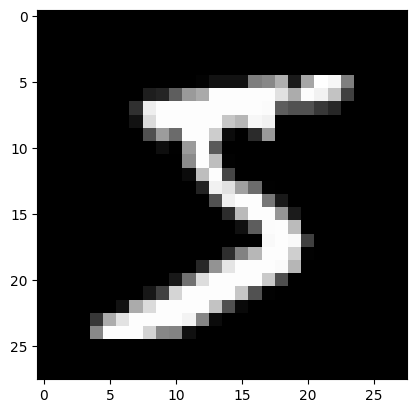

In [6]:
# inspect data
idx = 0
row = train_df.iloc[idx]

img_data = np.array(row.drop("label"))
img_data = img_data.reshape(28, 28)
img_data = np.expand_dims(img_data, axis=2)

label = row["label"]
print(f"label: {label}")

plt.imshow(img_data, cmap='gray')        # need (28,28,1) -> (H,W,C)  for plotting
plt.show()

In [7]:
# start

In [8]:
# make val out of train too
train_val = np.array(train_df)

# 50k, 10k, 10k
train_data = train_val[0:50000, :]
val_data = train_val[50000:, :]
test_data = np.array(test_df)

print(f"train len: {len(train_data)}")
print(f"val len: {len(val_data)}")
print(f"test len: {len(test_data)}")


train len: 50000
val len: 10000
test len: 10000


In [9]:
X_train = train_data[:, 1:].T
y_train = train_data[:, 0]      # vector

X_val = val_data[:, 1:].T
y_val = val_data[:, 0]

X_test = test_data[:, 1:].T
y_test = test_data[:, 0]


In [10]:
# normalisation 0 to 1 instead of 0 to 255

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [11]:
# data loaders for batches

class DataLoader:
    def __init__(self, X, y, batch_size, shuffle=False, seed=42):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_features, self.n_samples = X.shape

        self.rng = np.random.default_rng(seed)

    def __iter__(self):
        if self.shuffle == True:            # remove idices already used
            idx = self.rng.permutation(self.n_samples)    # use rng from above
        else:
            idx = np.arange(self.n_samples)     # [0 to n_samples]

        for start in range(0, self.n_samples, self.batch_size):
            b = idx[start:start + self.batch_size]
            yield self.X[:, b], self.y[b]


train_set = DataLoader(X_train, y_train, batch_size=100, shuffle=True, seed=42)
val_set = DataLoader(X_val, y_val, batch_size=100, seed=42)
test_set = DataLoader(X_test, y_test, batch_size=100, seed=42)



In [ ]:

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0) # need to sum each col

def one_hot(y, num_classes=10):
    one_hot_y = np.zeros((num_classes, len(y))) # 10 x m

    #for idx, val in enumerate(y):
        #one_hot_y[val,idx] = 1.0

    one_hot_y[y, np.arange(len(y))] = 1.0
    
    return one_hot_y


def get_preds(probs):
    return np.argmax(probs, axis=0) # return y_hat
    


In [ ]:
from abc import ABC, abstractmethod

class Module(ABC):
    def __init__(self):
        pass
    
    @abstractmethod
    def forward(self):
        pass

    @abstractmethod
    def backward(self):
        pass



class SoftmaxCrossEntropyLoss(Module):     # (10, 50k)

    def __call__(self, logits, y):
        return self.forward(logits, y)

    def forward(self, logits, y):

        self.y = y
        self.probs = softmax(logits)
        return np.mean(-np.log(self.probs[y,np.arange(len(y))]), axis=0)
    
    def backward(self):
        
        return self.probs - one_hot(self.y)


class ReLU(Module):
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
       
        relu_grad = (self.x > 0)
        return grad_output * relu_grad
    

class Dropout(Module):
    def __init__(self, p=0.2):  # prob of dropping a neuron
        self.p = p
        self.mask = None
        self.training = True

    def forward(self, x):
        if self.training:
            self.mask = (np.random.rand(*x.shape) > self.p) / (1 - self.p)  # inverted dropout
            return x * self.mask
        else:
            return x    # no dropout during inference
    
    def backward(self, gradient_output):
        return gradient_output * self.mask
    

In [ ]:
# backward requires 3 derivatives
# dW, db and dX to feed to previous layer

class Linear(Module):
    def __init__(self, in_features, out_features):

        # He initialisation
        self.W = np.random.randn(out_features, in_features) * np.sqrt(2.0/in_features)
        self.b = np.zeros((out_features, 1))

        self.dW = None
        self.db = None

    def forward(self, x): # (784, batch)
        self.x = x      # store for backprop
        return self.W @ x + self.b


    def backward(self, grad_output):    # dZ from next layer

        m = self.x.shape[1]     # n_samples

        self.dW = 1/m * grad_output @ self.x.T
        self.db = 1/m * np.sum(grad_output, axis=1, keepdims=True)

        grad_input =  self.W.T @ grad_output
        return grad_input
    
    def params(self):
        return [(self.W, self.dW, self.b, self.db)]
    


In [ ]:
class Dropout2D(Module):
    def __init__(self, p=0.1):  # prob of dropping a neuron
        self.p = p
        self.mask = None
        self.training = True

    def forward(self, x):   # drop entire channels instead of random pixels across all channels
        if self.training:
            batch, channels, h_in, w_in = x.shape
            self.mask = (np.random.rand(batch, channels, 1, 1) > self.p) / (1 - self.p)  # inverted dropout
            return x * self.mask
        else:
            return x    # no dropout during inference
    
    def backward(self, gradient_output):
        return gradient_output * self.mask


class Flatten(Module):
    
    def forward(self, x):   # (batch, channels, h, w) -> (vector, batch)

        self.input_shape = x.shape
        return x.reshape(-1, x.shape[0]) # (c*h*w, batch) this is what linear expects as input


    def backward(self, grad_out): # (c*h*w, batch) -> (batch, ch, h, w)

        return np.transpose(grad_out).reshape(self.input_shape)

       

class MaxPool(Module):
    def __init__(self, factor, stride=2, padding=0):

        if isinstance(factor, tuple): # is factor a tuple
            self.kernel_h = factor[0]
            self.kernel_w = factor[1]
        else:
            self.kernel_h = factor
            self.kernel_w = factor

        self.stride = stride
        self.padding = padding
    
    def forward(self, x):
        self.x = x

        batch_size, channels, h, w = x.shape
        P = self.padding

        if P > 0:   # not zero in case all negative numbers maxpool will return 0
            self.x_padded = np.full((batch_size, channels, h+2*P, w+2*P), -np.inf)
            self.x_padded[:, :, P:P+h, P:P+w] = x
        else:
            self.x_padded = x

        out_h = (h - self.kernel_h + 2*self.padding) // self.stride + 1
        out_w = (w - self.kernel_w + 2*self.padding) // self.stride + 1
    
        output = np.full((batch_size, channels, out_h, out_w), -np.inf)  
        
        # vectorise over batch and channels
        for i in range(out_h): 
            for j in range(out_w): 

                h_start, w_start = i*self.stride, j*self.stride
                h_end, w_end = h_start + self.kernel_h, w_start + self.kernel_w

                x_slice = self.x_padded[:,:, h_start:h_end, w_start:w_end]

                output[:,:,i,j] = np.max(x_slice, axis=(2,3))
            
        return output
    

    def backward(self, grad_out):

        out_h, out_w = grad_out.shape[2], grad_out.shape[3]

        grad_in = np.zeros_like(self.x_padded)

        for i in range(out_h):
            for j in range(out_w):

                h_start, w_start = i*self.stride, j*self.stride
                h_end, w_end = h_start + self.kernel_h, w_start + self.kernel_w

                x_slice = self.x_padded[:,:, h_start:h_end, w_start:w_end]

                max_val = np.max(x_slice, axis=(2,3), keepdims=True)
                local_mask = (max_val == x_slice)

                grad = grad_out[:,:,i,j][:,:,None,None]
                grad_in[:,:,h_start:h_end, w_start:w_end] += grad * local_mask

        if self.padding > 0:
            P = self.padding
            return grad_in[:,:,P:-P, P:-P]
        
        return grad_in


class AvgPool(Module):
    def __init__(self, factor, stride=2, padding=0):

        if isinstance(factor, tuple): # is factor a tuple
            self.kernel_h = factor[0]
            self.kernel_w = factor[1]
        else:
            self.kernel_h = factor
            self.kernel_w = factor

        self.stride = stride
        self.padding = padding
    
    def forward(self, x):
        self.x = x

        batch_size, channels, h, w = x.shape
        P = self.padding

        if P > 0:   # zero padded
            self.x_padded = np.zeros((batch_size, channels, h+2*P, w+2*P))
            self.x_padded[:, :, P:P+h, P:P+w] = x
        else:
            self.x_padded = x

        out_h = (h - self.kernel_h + 2*self.padding) // self.stride + 1
        out_w = (w - self.kernel_w + 2*self.padding) // self.stride + 1
    
        output = np.zeros((batch_size, channels, out_h, out_w))  
        
        # vectorise over batch and channels
        for i in range(out_h): 
            for j in range(out_w): 

                h_start, w_start = i*self.stride, j*self.stride
                h_end, w_end = h_start + self.kernel_h, w_start + self.kernel_w

                x_slice = self.x_padded[:,:, h_start:h_end, w_start:w_end]

                output[:,:,i,j] = np.mean(x_slice, axis=(2,3))
            
        return output
    

    def backward(self, grad_out):

        out_h, out_w = grad_out.shape[2], grad_out.shape[3]

        grad_in = np.zeros_like(self.x_padded)

        N = self.kernel_h*self.kernel_w

        for i in range(out_h):
            for j in range(out_w):

                h_start, w_start = i*self.stride, j*self.stride
                h_end, w_end = h_start + self.kernel_h, w_start + self.kernel_w

                ########?
                grad = grad_out[:,:,i,j][:,:,None,None]    # give each pixel equal split of gradient
                grad_in[:,:,h_start:h_end, w_start:w_end] += grad/N

        if self.padding > 0:
            P = self.padding
            return grad_in[:,:,P:-P, P:-P]
        
        return grad_in


In [5]:
import numpy as np
x = np.random.rand(4, 2) # vec, b
print(x,"\n")
y = x.T.reshape(x.shape[1], 1, 2, 2)
print(y)

[[0.59617056 0.88860609]
 [0.40833054 0.30313269]
 [0.5351949  0.75234267]
 [0.9908327  0.82811997]] 

[[[[0.59617056 0.40833054]
   [0.5351949  0.9908327 ]]]


 [[[0.88860609 0.30313269]
   [0.75234267 0.82811997]]]]


In [ ]:


class Conv2d(Module):   
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels

        if isinstance(kernel_size, tuple):
            self.kernel_h, self.kernel_w = kernel_size[0], kernel_size[1]
        else:
            self.kernel_h, self.kernel_w = kernel_size
        
        self.stride = stride
        self.padding = padding

        # the kernel - He initialisation
        fan_in = in_channels * self.kernel_h * self.kernel_w
        self.W = np.random.randn(out_channels, in_channels, self.kernel_h, self.kernel_w) * np.sqrt(2.0 / fan_in)
        self.b = np.zeros(out_channels)

        self.dW = None
        self.db = None
        
        self.x_padded = None

    # x -> (784, 50k)
    def forward(self, x):   # In (784, batch) reshape (b, c, h, w)   Output feature map (C_out, H', W')

        if x.ndim == 2:
                    # (784,b) -> (b,784) -> (b, 1, 28, 28)
            self.x = np.transpose(x).reshape(x.shape[1], 1, 28, 28)
        else:
            self.x = x

        batch_size, C_in, height, width = self.x.shape
        P = self.padding

        if P != 0:
            self.x_padded = np.zeros((batch_size, C_in, height+2*P, width+2*P))
            self.x_padded[:, :, P:P+height, P:P+width] = self.x
        else:
            self.x_padded = self.x


        new_width = (width - self.kernel_w + 2*P) // self.stride + 1   # changed standard formula since input already padded
        new_height = (height - self.kernel_h + 2*P) // self.stride + 1

        output = np.zeros((batch_size, self.out_channels, new_height, new_width))

        for b in range(batch_size):
            for i in range(new_height):
                for j in range(new_width):

                    h_start, w_start = i*self.stride, j*self.stride
                    h_end, w_end = h_start + self.kernel_h, w_start + self.kernel_w

                    x_slice = self.x_padded[b, :, h_start:h_end, w_start:w_end]

                    for f in range(self.out_channels):
                        output[b, f, i, j] = np.sum(x_slice * self.W[f]) + self.b[f]

        return output   # z
        
    
    def backward(self, grad_out):
        
        # grad_out - (batch, channels, h, w)
        batch_size, out_channels, h_out, w_out = grad_out.shape

        # init
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        grad_in = np.zeros_like(self.x_padded)

        # 1. dL/db
        self.db = np.sum(grad_out, axis=(0,2,3)) # one b value for each filter

        # 2. dL/dW = conv(x, dL/dz)
        # 3. dL/dx

        for b in range(batch_size):
            for i in range(h_out):
                for j in range(w_out):

                    h_start, w_start = i*self.stride, j*self.stride
                    h_end, w_end = h_start + self.kernel_h, w_start + self.kernel_w

                    grad_pixel = grad_out[b,:,i,j] # gradient vector for specific pixel for all channels in this image
                    x_slice = self.x_padded[b,:, h_start:h_end, w_start:w_end]
                    
                    for f in range(self.out_channels):
                        grad = grad_pixel[f]

                        # dW update
                        self.dW[f] += grad * x_slice

                        # dX update
                        grad_in[b,:, h_start:h_end, w_start:w_end] += self.W[f] * grad
        
        # normalise
        self.dW = self.dW / batch_size
        self.db = self.db / batch_size

        if self.padding > 0:
            P = self.padding
            return grad_in[:,:,P:-P, P:-P]
        
        return grad_in
    

    def params(self):
        return [(self.W, self.dW, self.b, self.db)]
        

In [ ]:

class Sequential(Module):
    def __init__(self, layers): 
        self.layers = layers

    def __call__(self, x):      # dont need to do .forward()
        return self.forward(x)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad_output):
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output
    
    def train(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = True

    def eval(self):
        for layer in self.layers:
            if hasattr(layer, 'training'):
                layer.training = False

    def load_params(self, saved_params):
        param_idx = 0
        for layer in self.layers:
            if hasattr(layer, 'params'):
                W, b = saved_params[param_idx]
                layer.W = W.copy()
                layer.b = b.copy()
                param_idx += 1

    def params(self):
        all_params = []
        for layer in self.layers:
            if hasattr(layer, 'params'):
                all_params.extend(layer.params())
                
        return all_params
    
    # [
    #   (W1, dW1, b1, db1), 
    #   (W2, dW2, b2, db2),   
    # ]

In [ ]:
class SGD:
    def __init__(self, model, lr, weight_decay=0.0, momentum=0.9):
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum

        self.velocities = None

    def step(self):
        params = self.model.params()

        # init velocities on first step
        if self.velocities is None and self.momentum > 0.0:
            self.velocities = []
            for W, dW, b, db in params:
                self.velocities.append({
                    'W': np.zeros_like(W),
                    'b': np.zeros_like(b)
                })

        for i, (W, dW, b, db) in enumerate(params):

            if self.momentum > 0.0: 
                self.velocities[i]['W'] = self.momentum * self.velocities[i]['W'] + (1-self.momentum)*dW
                self.velocities[i]['b'] = self.momentum * self.velocities[i]['b'] + (1-self.momentum)*db
                
                W -= self.lr * (self.velocities[i]['W'] + self.weight_decay * W)
                b -= self.lr * self.velocities[i]['b']

            else:
                W -= self.lr * (dW + self.weight_decay * W)
                b -= self.lr * db


class AdamW:
    def __init__(self, model, lr, weight_decay=0.0):
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay

        self.m = None   # first moment - mean
        self.v = None   # second moment - variance
        self.b1 = 0.9
        self.b2 = 0.999
        self.eps = 1e-8

        self.t = 1

    def step(self):
        params = self.model.params()

        # init velocities and s on first step
        if self.m is None and self.v is None:
            self.m = []
            self.v = []
            for W, dW, b, db in params:
                self.m.append({'W': np.zeros_like(W), 'b': np.zeros_like(b)})
                self.v.append({'W': np.zeros_like(W), 'b': np.zeros_like(b)})


        for i, (W, dW, b, db) in enumerate(params):

            self.m[i]['W'] = self.b1 * self.m[i]['W'] + (1-self.b1)*dW
            self.m[i]['b'] = self.b1 * self.m[i]['b'] + (1-self.b1)*db

            self.v[i]['W'] = self.b2 * self.v[i]['W'] + (1-self.b2) * dW**2
            self.v[i]['b'] = self.b2 * self.v[i]['b'] + (1-self.b2) * db**2
            
            # bias correction
            m_hat_W = self.m[i]['W'] / (1 - self.b1**self.t)
            m_hat_b = self.m[i]['b'] / (1 - self.b1**self.t)
            v_hat_W = self.v[i]['W'] / (1 - self.b2**self.t)
            v_hat_b = self.v[i]['b'] / (1 - self.b2**self.t)

            W -= self.lr * (m_hat_W / (np.sqrt(v_hat_W) + self.eps) + self.weight_decay * W)
            b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.eps)
        
        self.t += 1

In [40]:
#   m = β1 * m + (1 - β1) * gradient           # momentum (like SGD momentum)
#   v = β2 * v + (1 - β2) * gradient²          # tracks gradient variance

#   m_hat = m / (1 - β1^t)                     # bias correction (early steps)
#   v_hat = v / (1 - β2^t)

#   W -= lr * m_hat / (√v_hat + ε)             # adaptive learning rate per param


In [ ]:

def gradient_descent(model, optimizer, criterion, train_dataset, val_dataset, num_iter):


    best_val_acc = 0.0
    
    for epoch in range(num_iter):

        model.train()
        train_correct = 0
        total_train_loss = 0.0

        # train
        for X, y in train_dataset:

            # forward
            logits = model(X)

            loss = criterion(logits, y)

            total_train_loss += loss

            # backward
            grad_out = loss.backward() # loss
            model.backward(grad_out)

            # update weights
            optimizer.step()
            
            y_hat = get_preds(logits) # same as taking argmax of probs
            train_correct += (y_hat==y).sum()


        model.eval()
        val_correct = 0
        total_val_loss = 0.0
        
        # val
        for X, y in val_dataset:

            logits = model(X)
            loss = criterion(logits, y)

            total_val_loss += loss

            y_hat = get_preds(logits)
            val_correct += (y_hat==y).sum()

        avg_train_loss = total_train_loss / (train_dataset.n_samples // train_dataset.batch_size)###
        train_acc = train_correct / train_dataset.n_samples * 100.0

        avg_val_loss = total_val_loss / (val_dataset.n_samples // val_dataset.batch_size)###
        val_acc = val_correct / val_dataset.n_samples * 100.0


        if epoch % 10 == 0:
            print(f"Epoch: {epoch}  train loss: {avg_train_loss:.4f}    train acc: {train_acc:.2f}%     val loss: {avg_val_loss:.4f}    val acc: {val_acc:.2f}%")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            
            best_params = [(W.copy(), b.copy()) for W, _, b, _ in model.params()]    # save best weights
        
    return best_params

In [ ]:
import os

#model_dir = 'scratch_models'
#os.makedirs(model_dir, exist_ok=True)


model = Sequential([
    Linear(784, 100),
    ReLU(),
    Dropout(0.2),
    Linear(100, 10)
])

#optimizer = SGD(model=model, lr=1.5, weight_decay=0.0, momentum=0.9)
optimizer = Adam(model=model, lr=0.01, weight_decay=0)
criterion = SoftmaxCrossEntropyLoss()

# training
best_params = gradient_descent(model, optimizer, criterion, train_set, val_set, num_iter=201) # get final weights

Epoch: 0  train loss: 0.3050    train acc: 90.66%     val loss: 0.1371    val acc: 95.93%
Epoch: 10  train loss: 0.1173    train acc: 96.48%     val loss: 0.1310    val acc: 97.18%
Epoch: 20  train loss: 0.0955    train acc: 97.30%     val loss: 0.1892    val acc: 97.06%
Epoch: 30  train loss: 0.0886    train acc: 97.61%     val loss: 0.1884    val acc: 97.31%
Epoch: 40  train loss: 0.0831    train acc: 97.77%     val loss: 0.1958    val acc: 97.00%
Epoch: 50  train loss: 0.0820    train acc: 97.94%     val loss: 0.2203    val acc: 97.35%
Epoch: 60  train loss: 0.0794    train acc: 98.08%     val loss: 0.2414    val acc: 97.06%
Epoch: 70  train loss: 0.0698    train acc: 98.31%     val loss: 0.2945    val acc: 97.10%
Epoch: 80  train loss: 0.0741    train acc: 98.26%     val loss: 0.2863    val acc: 97.25%
Epoch: 90  train loss: 0.0653    train acc: 98.47%     val loss: 0.3247    val acc: 96.93%
Epoch: 100  train loss: 0.0646    train acc: 98.51%     val loss: 0.3599    val acc: 97.03%

In [19]:
# eval

model.eval()
model.load_params(best_params)

correct = 0

for X, y in test_set:
    logits = model.forward(X)
    probs = softmax(logits)
    
    y_hat_test = get_preds(probs)

    correct += (y_hat_test==y).sum()

test_acc = correct / test_set.n_samples * 100.0

print(f"test acc: {test_acc:.2f}%")


test acc: 97.22%
